In [1]:
import matplotlib.pyplot as plt
import numpy as np
from joblib import dump, load
from tqdm import tqdm
import pandas as pd
tqdm.pandas(ascii=True)
import seaborn as sns
import tensorflow as tf 
import os
os.environ["CUDA_VISIBLE_DEVICES"]="5"
#tf.enable_eager_execution()

/home/sxh/anaconda3/envs/my-rdkit-env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sxh/anaconda3/envs/my-rdkit-env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sxh/anaconda3/envs/my-rdkit-env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sxh/anaconda3/envs/my-rdkit-env

In [2]:
from molmap import loadmap
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model


## Input feature maps

In [3]:
smiles = ['CC(=O)OC1=CC=CC=C1C(O)=O']
mp = loadmap('./optimized_descriptor.mp')
X = mp.batch_transform(smiles, n_jobs = 2)


100%|##########| 1/1 [00:00<00:00, 26.52it/s]


In [4]:
model = load_model('./solubility_MMND.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [5]:
df_train = pd.read_csv('../train.csv', index_col = 0)
df_valid = pd.read_csv('../valid.csv',  index_col = 0)
df_test = pd.read_csv('../test.csv',  index_col = 0)
df_etc = pd.read_csv('../etc.csv')
task = 'measured log solubility in mols per litre'
df_etc[task] = df_etc.Exp_LogS

df = df_train.append(df_valid).append(df_test).append(df_etc)
df = df.reset_index(drop=True)

train_idx = df.index[:len(df_train)]
valid_idx = df.index[len(df_train): len(df_train)+len(df_valid)]
test_idx = df.index[len(df_train)+len(df_valid): len(df_train)+len(df_valid) + len(df_test)]
etc_idx = df.index[-len(df_etc):]
len(train_idx), len(valid_idx), len(test_idx), len(etc_idx)

/home/sxh/anaconda3/envs/my-rdkit-env/lib/python3.6/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


(901, 113, 113, 120)

In [6]:
task_name = 'solubility'
tmp_feature_dir = './tmpignore'
if not os.path.exists(tmp_feature_dir):
    os.makedirs(tmp_feature_dir)
    
X1_name = os.path.join(tmp_feature_dir, 'X1_optimized_%s.data' % task_name)
if not os.path.exists(X1_name):
    mp1 = molmap.loadmap('./optimized_descriptor.mp')
    X1 = mp1.batch_transform(df.smiles, n_jobs = 8)
    dump(X1, X1_name)
else:
    X1 = load(X1_name)

In [7]:
Y = df[[task]].values

trainX = X1[train_idx]
trainY = Y[train_idx]

validX = X1[valid_idx]
validY = Y[valid_idx]


testX = X1[test_idx]
testY = Y[test_idx]

etcX = X1[etc_idx]
etcY = Y[etc_idx]


## The GMP 192 pca

In [8]:
def GetGMP192(X):
    layer = model.get_layer('global_max_pooling2d')
    activation_model = Model(inputs=model.input, outputs=layer.output)
    activation = activation_model.predict(X, batch_size = 256)
    return activation

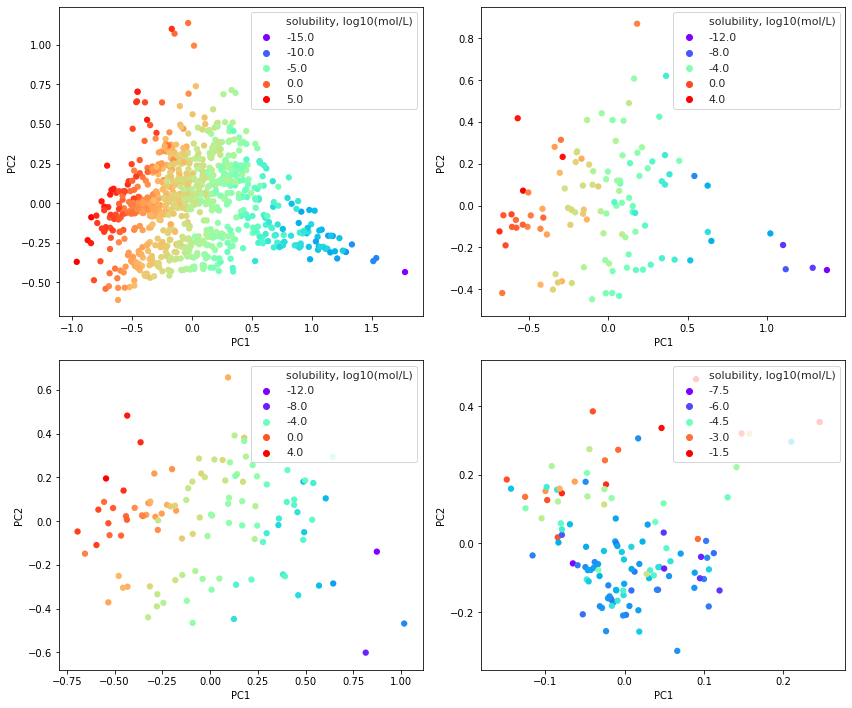

In [9]:
from sklearn.decomposition import PCA
f, (a, b ) = plt.subplots(2, 2, figsize=(12,10))
ax1, ax2 = a
ax3, ax4 = b

ax = [ax1, ax2, ax3, ax4]

i = 0
for x, y in  zip([trainX, validX, testX, etcX], [trainY, validY, testY, etcY]):
    X192 = GetGMP192(x)
    pca = PCA(n_components=2)
    embedd_2d = pca.fit_transform(X192)
    dft = pd.DataFrame(embedd_2d, columns = ['PC1', 'PC2'])
    name = 'solubility, log10(mol/L)'
    dft[name] = y
    sns.set(style="white")
    if i == 3:
        dft = dft.rename(columns = {'PC1':'PC2', 'PC2':'PC1'})        
    _ = sns.scatterplot('PC1','PC2',  hue = name, palette = 'rainbow', s = 40,  linewidth = 0, data = dft, ax = ax[i], ) #hue_order = order
    i += 1
    

plt.tight_layout()
plt.savefig('./result/global_max_pooling_192D.png', bbox_inches="tight", dpi = 400)


## The Leave One Out feature importance

In [10]:
n, w, h, c = trainX.shape
H_grid = mp.plot_grid(htmlpath = './result')
df_grid = mp.df_grid

2020-01-29 12:48:52,586 - INFO - [bidd-molmap] - generate file: ./result/descriptor_1344_cosine_umap_molmap
2020-01-29 12:48:52,629 - INFO - [bidd-molmap] - save html file to ./result/descriptor_1344_cosine_umap_molmap


In [11]:
from sklearn.metrics import mean_squared_error
from scipy.stats.stats import pearsonr
from copy import copy
def ForwardPropFeatureImp(model, X_true, Y_true, df_grid):
    '''
    Forward prop. Feature importance
    '''
    df_grid = df_grid.sort_values(['y', 'x']).reset_index(drop=True)
    Y = model.predict(X_true)
    mse = mean_squared_error(Y_true, Y)
    N, W, H, C = X_true.shape
    results = []
    for i in tqdm(range(len(df_grid)), ascii= True):
        ts = df_grid.iloc[i]
        y = ts.y
        x = ts.x
        X1 = copy(X_true)
        X1[:, y, x,:] = np.zeros(X1[:, y, x,:].shape)
        Y1 = model.predict(X1)
        mse_mutaion = mean_squared_error(Y_true, Y1)
        res = mse_mutaion - mse  # if res > 0, important, othervise, not important
        results.append(res)
            
    S = pd.Series(results, name = 'importance')
    df = df_grid.join(S)
    return df

In [12]:
train_imp = ForwardPropFeatureImp(model, trainX, trainY,  df_grid)
test_imp = ForwardPropFeatureImp(model, testX, testY,  df_grid)

100%|##########| 1369/1369 [00:19<00:00, 69.58it/s]


In [13]:
cols = ['Feature importance based on training set',  'Feature importance based on test set' ] 

In [14]:
dfp = pd.DataFrame([train_imp.importance.tolist(), 
                      test_imp.importance.tolist()], index = cols, columns = train_imp.v).T 

dfp['Subtypes'] = train_imp.Subtypes.tolist()
dfp['colors'] = train_imp.colors.tolist()
colormaps = mp.extract.colormaps

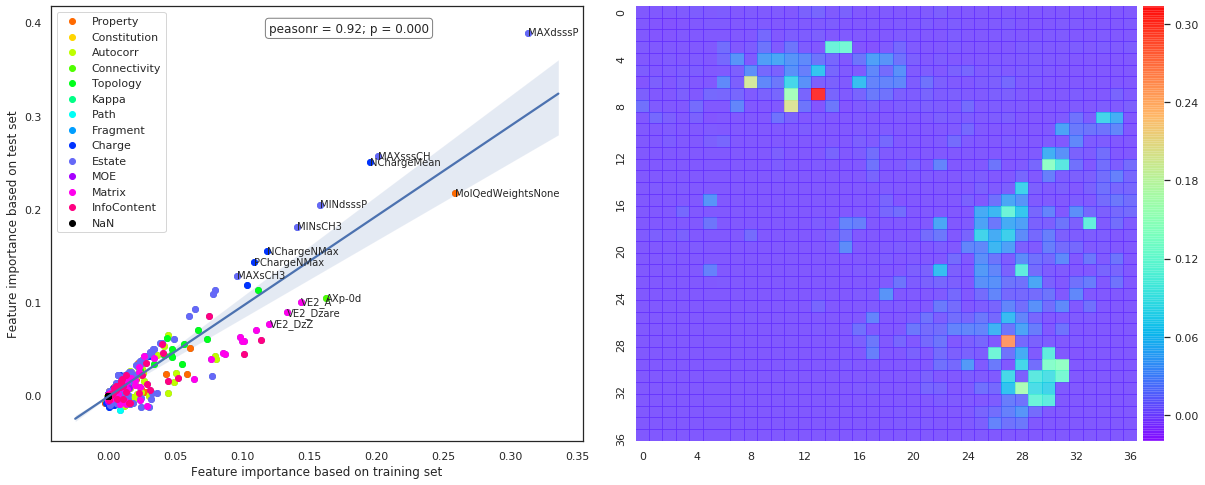

In [20]:
fig, (ax, ax2)  = plt.subplots(1, 2, figsize=(20, 8))
sns.regplot(dfp['Feature importance based on training set'], 
            dfp['Feature importance based on test set'], ax = ax)

for subtype, color in colormaps.items():
    dfi = dfp[dfp['Subtypes'] == subtype]

    x = dfi['Feature importance based on training set']
    y = dfi['Feature importance based on test set']
    ax.scatter(x, y, label = subtype, color = color)

for i,j in dfp.iterrows():
    x = j['Feature importance based on training set']
    y = j['Feature importance based on test set']
    if (x > 0.12) | (y > 0.12):
        ax.text(x,y,i, fontsize = 10, verticalalignment = 'center')
    
ax.text(0.12,0.39,'peasonr = 0.92; p = 0.000', bbox = {'boxstyle': 'round', 'facecolor': 'white', 'edgecolor':'gray'})
ax.legend()


imp = train_imp.join(test_imp.importance.to_frame(name = 'test_importance'))
IMPM = imp.importance.values.reshape(37,37)
sns.heatmap(IMPM,  cmap = 'rainbow', alpha = 0.8, xticklabels=4, yticklabels=4,
            ax = ax2, vmin = -0.02, cbar_kws = {'fraction':0.046, 'pad':0.01})

plt.subplots_adjust(wspace = 0.1)
plt.savefig('./result/feature_importance.png', dpi = 400, bbox_inches="tight")


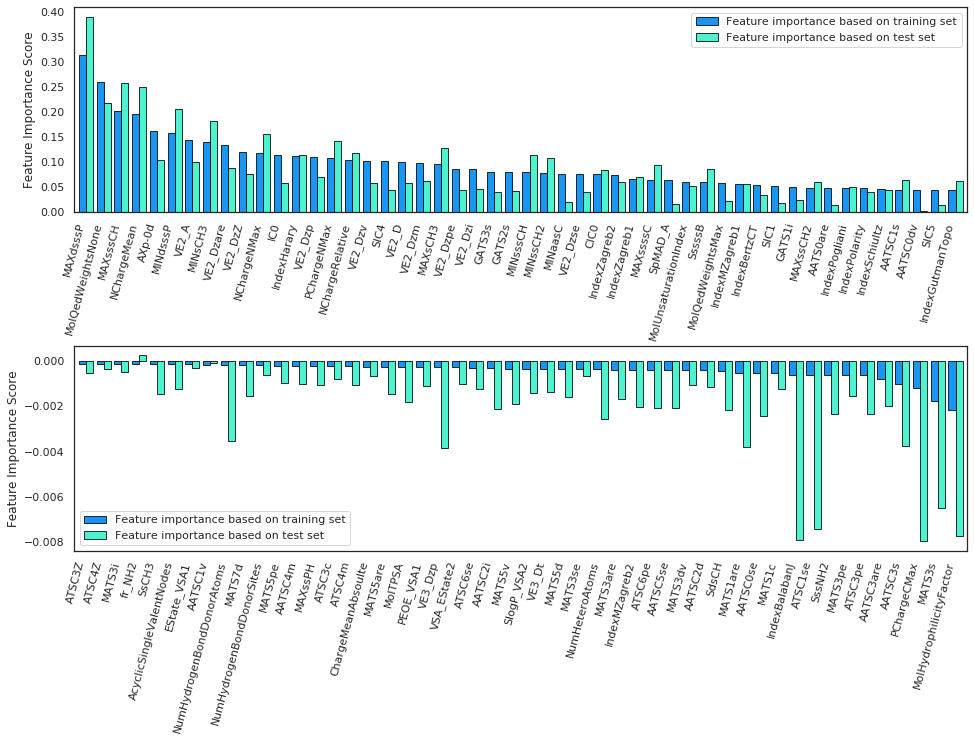

In [16]:

colors = sns.color_palette('rainbow', 4).as_hex()

f, (ax1, ax2 ) = plt.subplots(2, 1, figsize=(16,10))

df1 = dfp.sort_values('Feature importance based on training set',  ascending = False).head(50)
ax1 = df1.plot(kind = 'bar',ax = ax1, color = colors[0:2], width = 0.8, edgecolor='black', lw = 0.8)


df2 = dfp.sort_values('Feature importance based on training set', ascending = False).tail(50)
ax2 = df2.plot(kind = 'bar', ax = ax2, color = colors[0:2], width = 0.8, edgecolor='black', lw = 0.8 )

ax1.set_xticklabels(df1.index, rotation=75, ha='right')
ax2.set_xticklabels(df2.index, rotation=75, ha='right')

ax1.set_xlabel(None, fontsize='medium')
ax2.set_xlabel(None, fontsize='medium')

ax1.set_ylabel('Feature Importance Score', fontsize='medium')
ax2.set_ylabel('Feature Importance Score', fontsize='medium')

plt.subplots_adjust(hspace = 0.65)

plt.savefig('./result/feature_importance_rank.png', dpi = 400, bbox_inches="tight")